# Nota Importante
O propósito deste notebook é encontrar o melhor modelo para os dados Sem Outliers, mantendo a simplicidade do LinearRegression. Já fizemos diversas transformações de features e target com esse objetivo.

Vamos usar diferentes opções de hiperparâmetros para criar features polinomiais e encontrar um novo modelo melhor que o que temos até o momento.

Nesta etapa, ainda não vamos nos preocupar com regularização de coeficiente. Faremos isso em etapas posteriores.

---

Leia o arquivo [README.md](../README.md) para detalhes sobre a base o projeto.

Leia o arquivo de [01_dicionario_de_dados.md](../referencias/01_dicionario_de_dados.md) para detalhes sobre a base.

Ao importar esse arquivo [src.graficos](./src/graficos.py), em tema seaborn é aplicado.

# Imports e configurações

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
import seaborn as sns
import warnings


from sklearn.compose import ColumnTransformer # constrói um pipeline para diferentes colunas
from sklearn.linear_model import (
    LinearRegression, # modelo de regressão linear com coeficientes estimados usando o método dos mínimos quadrados
)
from sklearn.pipeline import Pipeline # enfileira diferentes procedimentos
from sklearn.preprocessing import (  # Módulo de pré-processamento de dados
    OneHotEncoder,       # Codifica variáveis categóricas nominais, transformando-as em uma matriz binária (uma coluna para cada categoria)
    OrdinalEncoder,      # Codifica variáveis categóricas ordinais, convertendo categorias em inteiros com base na ordem
    PolynomialFeatures,  # Cria features polinomiais e de multiplicação entre elas.
    PowerTransformer,    # Aplica uma transformação de potência para estabilizar a variância e tornar os dados mais gaussianos
    QuantileTransformer, # Realiza uma transformação baseada em quantis, escalando os dados para uma distribuição uniforme ou normal
    # RobustScaler,        # Normaliza os dados utilizando estatísticas robustas (mediana e intervalo interquartil), útil para dados com outliers
    StandardScaler,      # Normaliza os dados para que tenham média zero e desvio padrão um, útil para dados normalmente distribuídos
)

from src.auxiliares import (
    fnc_dataframe_coeficientes, # função que combina os coeficientes de um gridsearch com os nomes das features em um DataFrame
    fnc_describe_numericas_personalizado, # função que retorna um dataframe com o describe() de variáveis numéricas enriquecido com colunas de tipo, ausência, variabilidade, outliers e normalidade
    fnc_exibir_dataframe_resultados, # função que exibe um DataFrame estilizado no notebook ou um DataFrame simples no console
)
from src.config import (
    DADOS_X_TEST,
    DADOS_X_TRAIN,
    DADOS_X_VALIDATION,
    DADOS_Y_TEST,
    DADOS_Y_TRAIN,
    DADOS_Y_VALIDATION,
)
from src.graficos import (
    PALETTE_TEMPERATURA,
    plot_coeficientes, # função para plotar um gráfico de barras horizontais dos coeficientes de um modelo
    plot_comparar_metricas_modelos, # função para plotar boxplots de diferentes modelos para diferentes méticas de um dataframe de resultado
    plot_residuos_estimador, # função que plota 3 gráficos de resíduos para um estimador, um histograma e dois de dispersão
)
from src.models import (
    fnc_grid_search_cv_regressor, # função para planejar modelos de regressão validação cruzada e grid search
    fnc_treinar_e_validar_modelos_regressao, # função para treinar modelos de regressão com validação cruzada usando um dicionário de regressores
)

In [2]:
pd.options.display.max_rows = 15
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format

# Ignorar UserWarnings
warnings.filterwarnings('ignore', category=UserWarning)

# Modelagem para melhoria do modelo da etapa 3

## Carregando os arquivos de treino/teste e validação criados na etapa 2

Origem: [01-ild-eda.ipynb](01-ild-eda.ipynb)

- `median_income`: renda mediana no grupo de blocos (em dezenas de milhares de dólares)
- `housing_median_age`: idade mediana das casas no grupo de blocos
- `total_rooms`: número cômodos no grupo de blocos
- `total_bedrooms`: número de quartos no grupo de blocos
- `population`: população do grupo de blocos
- `households`: domicílios no grupo de blocos
- `latitude`: latitude do grupo de blocos
- `longitude`: longitude do grupo de blocos
- `ocean_proximity`: proximidade do oceano
  - `NEAR BAY`: perto da baía
  - `<1H OCEAN`: a menos de uma hora do oceano
  - `INLAND`: no interior
  - `NEAR OCEAN`: perto do oceano
- `median_house_value`: valor mediano das casas no grupo de blocos (em dólares)
- `median_income_cat`: categorias baseadas no valor da mediana do salário anual -> `median_income`
- `housing_median_age_cat`: categorias baseadas no valor da mediana das idades das casas -> `housing_median_age`
- `population_cat`: categorias baseadas no tamanho da população -> `population`
- `rooms_per_household`: `total_rooms` / `households`
- `population_per_household`: `population` / `households`
- `bedrooms_per_room`: `total_bedrooms` / `total_rooms`

In [3]:
# dados já separados como X e y de treino, teste e validação
X_train = pd.read_parquet(DADOS_X_TRAIN)
y_train = pd.read_parquet(DADOS_Y_TRAIN)

print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

X_train.shape (12862, 15)
y_train.shape (12862, 1)


In [4]:
display(
    X_train.head(1),
    y_train.head(1),
)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
4816,-118.28,33.91,41,620,133,642,162,2.65,<1H OCEAN,1.5 <= x < 3,40 <= x,500 <= x < 1000,3.83,3.96,0.21


,median_house_value
4816,159600


## Definindo as estratégias para os modelos
Vamos manter a estratégia ganhadora do GRID SEARCH da etapa anterior e vamos experimentar criar features polinomiais nas variáveis originalmente númericas.

In [5]:
coluna_target = ['median_house_value']

# define as colunas a serem transformadas 
colunas_one_hot_encoder = ['ocean_proximity',]
colunas_ordinal_encoder = ['median_income_cat', 'housing_median_age_cat', 'population_cat',]
colunas_standard_scaler_poly = ['longitude', 'latitude', 'housing_median_age']
colunas_power_tranformer_poly = X_train.columns.difference( # colunas restantes com outliers
    colunas_one_hot_encoder + colunas_ordinal_encoder + colunas_standard_scaler_poly
).to_list()


preprocessamento_categoricas = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(drop='first'), colunas_one_hot_encoder), # drop='first' para evitar a dummy variable trap
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), colunas_ordinal_encoder), # categories='auto' para usar as categorias do dataframe
    ],
    remainder='passthrough', # mantém as colunas que não foram transformadas
)



preprocessamento_standard_power_box_cox = ColumnTransformer(
    transformers=preprocessamento_categoricas.transformers + [
        ('standard_scaler', StandardScaler(), colunas_standard_scaler_poly),
        ('power_transformer', PowerTransformer(method='box-cox'), colunas_power_tranformer_poly), # box-cox só funciona para números positivos
    ],
)



# enfileira uma transformação depois de outra
pipeline_standard_poly = Pipeline(
    steps=(
        ('standard_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=1, interaction_only=False, include_bias=False)),
    ),
)

# enfileira uma transformação depois de outra
pipeline_power_poly = Pipeline(
    steps=(
        ('power_transformer', PowerTransformer(method='box-cox')), # box-cox só funciona para números positivos
        ('poly', PolynomialFeatures(degree=1, interaction_only=False, include_bias=False)),
    ),
)

# define o preprocessamento das colunas - o preprocessamento é feito em ordem
preprocessamento_polinomiais = ColumnTransformer(
    transformers=preprocessamento_categoricas.transformers + [
        ('standard_scaler_poly', pipeline_standard_poly, colunas_standard_scaler_poly),
        ('power_transformer_poly', pipeline_power_poly, colunas_power_tranformer_poly),
    ],
)



target_transfomer = QuantileTransformer(output_distribution='normal')



# algorítmos de avaliação de modelos de regressão a utilizar nessa análise - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
dct_metricas_modelos = {
        # 'd2_absolute_error_score'            : 'd2ae',  # melhor = 1.0 -> metrics.d2_absolute_error_score
        # 'explained_variance'                 : 'evs',   # melhor = 1.0 -> metrics.explained_variance_score
        # 'neg_max_error'                      : 'maxe',  # melhor = 0.0 -> metrics.max_error
        'neg_mean_absolute_error'            : 'mae',   # melhor = 0.0 -> metrics.mean_absolute_error
        # 'neg_mean_absolute_percentage_error' : 'mape',  # melhor = 0.0 -> metrics.mean_absolute_percentage_error
        # 'neg_mean_gamma_deviance'            : 'mgd',   # melhor = 0.0 -> metrics.mean_gamma_deviance
        # 'neg_mean_poisson_deviance'          : 'mpd',   # melhor = 0.0 -> metrics.mean_poisson_deviance
        # 'neg_mean_squared_error'             : 'mse',   # melhor = 0.0 -> metrics.mean_squared_error
        # 'neg_mean_squared_log_error'         : 'msle',  # melhor = 0.0 -> metrics.mean_squared_log_error
        # 'neg_median_absolute_error'          : 'medae', # melhor = 0.0 -> metrics.median_absolute_error
        'neg_root_mean_squared_error'        : 'rmse',  # melhor = 0.0 -> metrics.root_mean_squared_error
        # 'neg_root_mean_squared_log_error'    : 'rmsle', # melhor = 0.0 -> metrics.root_mean_squared_log_error
        'r2'                                 : 'r2',    # melhor = 1.0 -> metrics.r2_score
}


refit = 'neg_root_mean_squared_error' # algorítmos de avaliação de modelos de regressão que será usado como avaliador do melhor modelo


## Estratégia de Grid Search para a criação de features polinomiais
São muitas alternativas, além disso gerar muitos mais processamento, também pode levar à overfitting.
Mas temos a base de validação que não participará dos treinamentos e testes para avaliarmos isso.
Lembrando que um alto volume de dados poderia demorar demais e tornar impossível fazer esse procedimento, nos forçando a escolher menos possibilidades.

In [6]:
# essa nova estratégia será somada à estratégia já conhecida na parte de target.
# lembrando que muitos cenários e muitos registros podem levar à lentidão no processamento.
param_grid = {
    'regressor__preprocessor__standard_scaler_poly__poly__degree': (1, 2, 3),
    'regressor__preprocessor__standard_scaler_poly__poly__interaction_only': (False, True),
    'regressor__preprocessor__standard_scaler_poly__poly__include_bias': (False, True),

    'regressor__preprocessor__power_transformer_poly__poly__degree': (1, 2, 3),
    'regressor__preprocessor__power_transformer_poly__poly__interaction_only': (False, True),
    'regressor__preprocessor__power_transformer_poly__poly__include_bias': (False, True),
}


## Construindo o plano de execução com as novas estratégias/cenários
grid_search = fnc_grid_search_cv_regressor(
    preprocessor=preprocessamento_polinomiais, # obrigatório se no grid search tentar variar o preprocessamento
    regressor=LinearRegression(),
    target_transformer=target_transfomer,
    param_grid=param_grid,
    scoring=tuple(dct_metricas_modelos.keys()),
    refit = refit,
)


grid_search


GridSearchCV(cv=KFold(n_splits=5, random_state=255, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat',
                                                                                                               'housing_median_age_cat',
                                                                                                               'population_cat']),
                                                                                                             ('stan...
                         'regressor__preprocessor__standard_scaler_poly__poly__degree': (1,
                                                                                         2,
                                                                                         3),
                         'regressor__preprocessor__standard_scaler_poly__poly__include_bias': (False,
                                                                                               True),
                         'regressor__preprocessor__standard_scaler_poly__poly__interaction_only': (False,
                                                                                                   True)},
             refit='neg_root_mean_squared_error',
             scoring=('neg_mean_absolute_error', 'neg_root_mean_squared_error',
                      'r2'),
             verbose=1)

## Treinando e avaliando os modelos de acordo com o plano construído acima
Nesse etapa conseguimos saber quais são os melhores hiperparametros que entregaram o melhor modelo

In [7]:
grid_search.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=255, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat',
                                                                                                               'housing_median_age_cat',
                                                                                                               'population_cat']),
                                                                                                             ('stan...
                         'regressor__preprocessor__standard_scaler_poly__poly__degree': (1,
                                                                                         2,
                                                                                         3),
                         'regressor__preprocessor__standard_scaler_poly__poly__include_bias': (False,
                                                                                               True),
                         'regressor__preprocessor__standard_scaler_poly__poly__interaction_only': (False,
                                                                                                   True)},
             refit='neg_root_mean_squared_error',
             scoring=('neg_mean_absolute_error', 'neg_root_mean_squared_error',
                      'r2'),
             verbose=1)

In [8]:
# informa os melhores parametros encontrados pelo GRID SEARCH
# no nosso caso, só planejamos a busca na transformação de target
grid_search.best_params_

{'regressor__preprocessor__power_transformer_poly__poly__degree': 3,
 'regressor__preprocessor__power_transformer_poly__poly__include_bias': False,
 'regressor__preprocessor__power_transformer_poly__poly__interaction_only': True,
 'regressor__preprocessor__standard_scaler_poly__poly__degree': 3,
 'regressor__preprocessor__standard_scaler_poly__poly__include_bias': False,
 'regressor__preprocessor__standard_scaler_poly__poly__interaction_only': False}

In [9]:
# se refere à metrica escolhida para comparação na variável 'refit' da estratégia do GRID SEARCH
grid_search.best_score_

-52439.03695617556

### Sobre o melhor modelo
- Vemos que foram 720 jobs/fits/processamentos, pois foram 144 alternativas de pré-processamento e 5 validações cruzadas [o default da função em `n_splits`];
- A melhor alternativa de pré-processamento foi com [degree=3] para todas as numéricas e [interaction_only=True] no caso das transformadas pelo `PowerTransformer()`.
- Lembrando que considerando o `RMSE` como validador, que na versão original, tinha vencido na média e mediana a versão sem transformação de target;

Tivemos então uma melhoria do modelo usando `StandardScaler` e `PowerTransformer(method='box-cox')` combinados com a criação de features polinomiais com `PolynomialFeatures()`. Vamos avaliar esse modelo antes de partir para novas melhorias.

Acredito que as 144 alternativas processadas para melhorar essas features sejam aceitáveis para nosso contexto de poucos registros. Para bases maiores, não seria viável tantas opções, visto que já gastamos alguns minutos processando.
Para tentar melhorar o modelo ainda mais, podemos partir para a regularização dos coeficientes, que faremos na próxima etapa.

## Avaliando o melhor modelo criado

In [10]:
# se esse numero for muito grande, melhor apresentar num dataframe vertical
# por causa das configurações de pandas feitas no inicio
len(grid_search.best_estimator_.regressor_['regressor'].coef_)

117

117 é variável demais para visualizar, vamos ver apenas as primeiras mais relevantes para o modelo.

In [11]:
df_coeficientes = fnc_dataframe_coeficientes(
    colunas      = grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
    coeficientes = grid_search.best_estimator_.regressor_['regressor'].coef_,
    flg_mostrar_dataframe=False,
    flg_horizontal=False,
)
df_coeficientes.head()

,coeficiente
power_transformer_poly__population total_rooms,-199.48
power_transformer_poly__population total_bedrooms,186.46
power_transformer_poly__households total_bedrooms,-178.00
power_transformer_poly__households total_rooms,159.83
power_transformer_poly__bedrooms_per_room households,63.31


In [12]:
df_coeficientes.tail().style.format(precision=10)

,coeficiente
ordinal_encoder__housing_median_age_cat,0.0136664469
ordinal_encoder__median_income_cat,-0.0097331687
power_transformer_poly__median_income total_bedrooms total_rooms,-0.0065072433
ordinal_encoder__population_cat,-0.0026942787
standard_scaler_poly__housing_median_age^3,0.0011969235


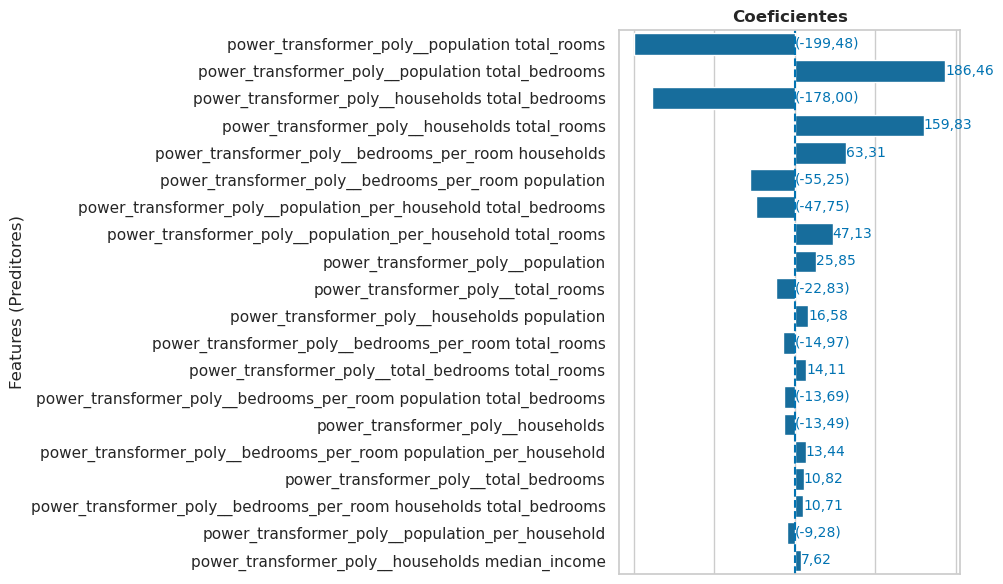

In [13]:
plot_coeficientes(df_coeficientes, precisao=2,)

Podemos ver que as primeiras features em relevância não são as de polinônio, apesar do [degree=3]. A combinação entre as diversas variáveis acabou sendo mais relevante.
- Compararando com a etapa anterior, podemos ver que a transformação das variáveis foi capaz de trocar bastante a relevância das variáveis para o modelo, trocando bastante sua ordem.

Quase todas as features tiveram alguma contribuição para o novo modelo, mas algumas tiveram um coeficiente bem pequeno. Uma epata de regularização pode eliminar algumas colunas do modelo e trazer ganhos de precisão.

## Vamos comparar nosso novo melhor modelo com os que tinhamos antes

In [14]:
# regressores atualizado com a melhor estratégia encontrada pelo GRID SEARCH
# apenas para comparar com o melhor modelo que sairá do grid search
regressors = {
    # Modelo incial simples apenas para comparação
    'LinearRegression_simples': {
        'preprocessor': preprocessamento_categoricas,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },

    # melhor até o momento,
    'LinearRegression_melhor_atual': {
        'preprocessor': preprocessamento_standard_power_box_cox,
        'regressor': LinearRegression(),
        'target_transformer': target_transfomer
    },

    # novo modelo indicado como melhor após o GRID SEARCH
    'LinearRegression_best_estimator': {
        'preprocessor':       grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor':          grid_search.best_estimator_.regressor_['regressor'],
        'target_transformer': grid_search.best_estimator_.transformer_,
    }
}

pprint(regressors)

{'LinearRegression_best_estimator': {'preprocessor': ColumnTransformer(transformers=[('one_hot_encoder', OneHotEncoder(drop='first'),
                                 ['ocean_proximity']),
                                ('ordinal_encoder', OrdinalEncoder(),
                                 ['median_income_cat', 'housing_median_age_cat',
                                  'population_cat']),
                                ('standard_scaler_poly',
                                 Pipeline(steps=(('standard_scaler',
                                                  StandardScaler()),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False)))),
                                 ['longitude',...,
                                  'housing_median_age']),
                                ('power_transformer_poly',
             

In [15]:
df_resultados = fnc_treinar_e_validar_modelos_regressao(
    X=X_train,
    y=y_train,
    regressors=regressors,
    scoring=tuple(dct_metricas_modelos.keys()),
)

fnc_exibir_dataframe_resultados(df_resultados)

Index(['model', 'fit_time', 'score_time', 'test_neg_mean_absolute_error',
       'test_neg_root_mean_squared_error', 'test_r2', 'time_seconds'],
      dtype='object')


,model,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time_seconds
0,LinearRegression_simples,0.081908,0.023756,-40752.245328,-55293.325335,0.649683,0.105664
1,LinearRegression_simples,0.057307,0.023490,-43153.132860,-65273.979368,0.537121,0.080797
2,LinearRegression_simples,0.047431,0.014438,-42344.177226,-58983.680481,0.625750,0.061869
3,LinearRegression_simples,0.028669,0.014035,-42839.980813,-58944.889944,0.635304,0.042703
4,LinearRegression_simples,0.029102,0.013538,-42373.880720,-58053.346421,0.625479,0.042641
5,LinearRegression_melhor_atual,0.977609,0.018870,-37920.136470,-52981.988365,0.678358,0.996480
6,LinearRegression_melhor_atual,0.980172,0.018654,-39595.225049,-55737.971515,0.662488,0.998826
7,LinearRegression_melhor_atual,1.095054,0.019497,-38879.909466,-54361.198777,0.682110,1.114551
8,LinearRegression_melhor_atual,1.043233,0.018550,-39286.717198,-56388.020427,0.666257,1.061783
9,LinearRegression_melhor_atual,1.168205,0.022426,-39872.792224,-56574.124920,0.644322,1.190631


In [16]:
fnc_exibir_dataframe_resultados(df_resultados.groupby('model').mean())

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time_seconds
model,,,,,,
LinearRegression_best_estimator,1.208378,0.028255,-36752.795634,-52444.047417,0.699308,1.236633
LinearRegression_melhor_atual,1.052855,0.019599,-39110.956081,-55208.660801,0.666707,1.072454
LinearRegression_simples,0.048883,0.017851,-42292.683389,-59309.844310,0.614667,0.066735


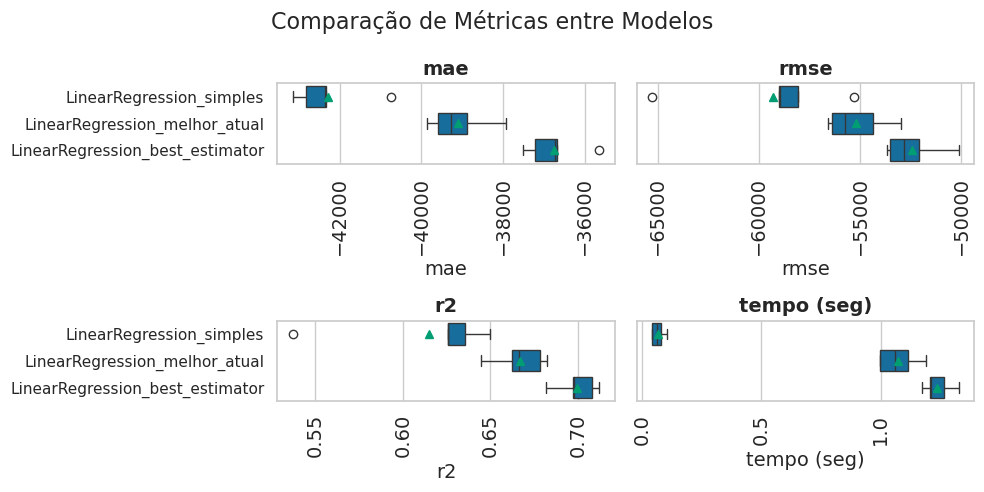

In [17]:
plot_comparar_metricas_modelos(
    df_resultados=df_resultados,
    comparar_metricas=['test_' + metrica for metrica in dct_metricas_modelos.keys()] + ['time_seconds'],
    nomes_metricas=list(dct_metricas_modelos.values()) + ['tempo (seg)'],
    figsize=(10, 5),
    colunas_graficos=2,
    flg_boxplots_horizontais=True,
)

### Sobre o novo modelo encontrado pelo GRID SEARCH
- O novo modelo encontrado pelo GRID SEARCH consegue vencer o nosso melhor modelo até então em todas as métricas de avaliação selecionadas. Média e mediana claramente superiores ao modelo anterior.
- O tempo de processamento até melhorou um pouco.
- Vamos considerar esse novo modelo como substituto do `LinearRegression_melhor_atual` que não fazia construía features polinomais.

Novas análises ainda serão feitas nas próximas etapas. Ainda podemos regularizações, iniciando com o ElasticNet e se tiver uma tendencia para Lasso ou Bridge, fazemos na seqüência.

Vamos analisar resíduos para comparar com as etapas anterior e posteriores.

## Resíduos do modelo novo

### Resíduos sobre a base de teste
Essa base não participou do treinamento em nenhum momento e são novos para o modelo.

In [18]:
# dados já separados como X e y de teste
X_test = pd.read_parquet(DADOS_X_TEST)
y_test = pd.read_parquet(DADOS_Y_TEST)

print('X_test.shape', X_test.shape)
print('y_test.shape', y_test.shape)

X_test.shape (3639, 15)
y_test.shape (3639, 1)


In [19]:
df_residuos = pd.DataFrame()
df_residuos['residuos'] = y_test - grid_search.predict(X_test)

df_describe = fnc_describe_numericas_personalizado(
    df=df_residuos,
    flg_mostrar_dataframe=False,
    flg_retornar_dataframe=True,
    teste_normalidade='Kolmogorov-Smirnov'
)

df_describe[['dist_normal', 'pvalue', 'teste_normalidade', 'skewness', 'kurtosis',]].T

/dados/app/conda/envs/california/lib/python3.12/site-packages/pandas/core/dtypes/cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


,residuos
dist_normal,False
pvalue,0
teste_normalidade,Kolmogorov-Smirnov
skewness,0.70
kurtosis,3.77


,min,LOWER,01%,25%,50%,75%,99%,UPPER,max,mean,std
residuos,-328748.685735,-103485.275971,-123576.463935,-25949.407394,-3248.291016,25741.171875,170256.061664,103277.040234,324922.480147,2679.809326,52630.839844


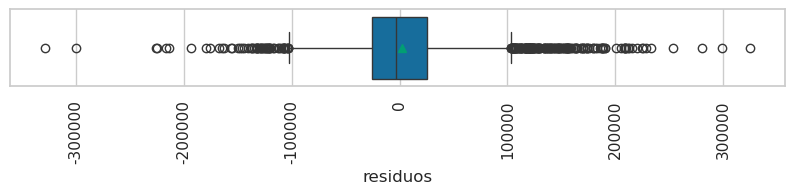

In [20]:
display(
    df_describe[['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean', 'std',
    ]].style.background_gradient(
        cmap=PALETTE_TEMPERATURA,
        axis='columns',
        subset=['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean',]
    )
)

# boxplot
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(
    data=df_residuos,
    x='residuos',
    showmeans=True,
    ax=ax,
)
# Definindo a orientação dos tick labels do eixo x na vertical
ax.set_xticklabels(
    labels=[int(x) for x in ax.get_xticks()],
    rotation=90,
)
plt.show()

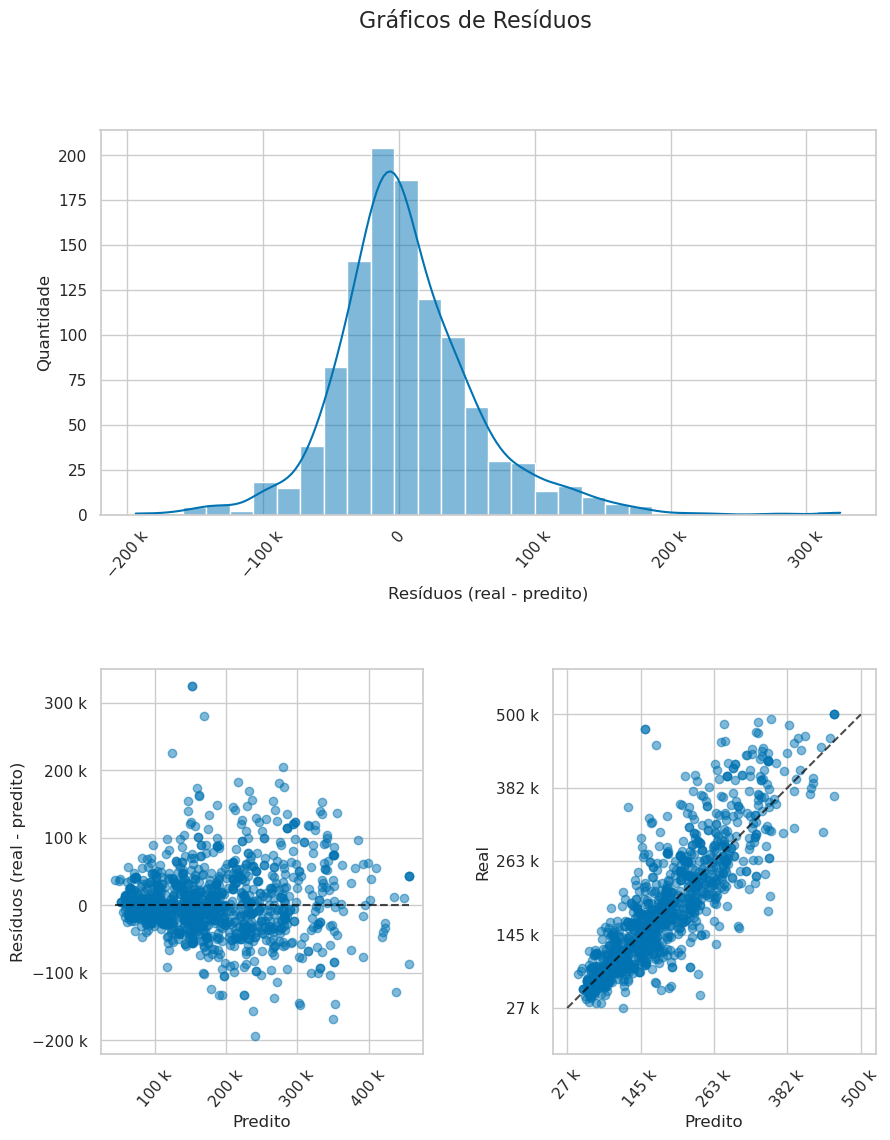

In [21]:
plot_residuos_estimador(grid_search.best_estimator_, X_test, y_test, fracao_amostra=0.3, eng_formatter=True) #, mosaico='bc;aa')

### Resíduos sobre a base de validação
Essa base não participou do treinamento em nenhum momento e são novos para o modelo.

In [22]:
y_validation = pd.read_parquet(DADOS_Y_VALIDATION)
X_validation = pd.read_parquet(DADOS_X_VALIDATION)

print('X_validation.shape', X_validation.shape)
print('y_validation.shape', y_validation.shape)

X_validation.shape (1874, 15)
y_validation.shape (1874, 1)


In [23]:
df_residuos = pd.DataFrame()
df_residuos['residuos'] = y_validation - grid_search.predict(X_validation)

df_describe = fnc_describe_numericas_personalizado(
    df=df_residuos,
    flg_mostrar_dataframe=False,
    flg_retornar_dataframe=True,
    teste_normalidade='Kolmogorov-Smirnov'
)

df_describe[['dist_normal', 'pvalue', 'teste_normalidade', 'skewness', 'kurtosis',]].T

/dados/app/conda/envs/california/lib/python3.12/site-packages/pandas/core/dtypes/cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


,residuos
dist_normal,False
pvalue,0
teste_normalidade,Kolmogorov-Smirnov
skewness,0.97
kurtosis,4.74


,min,LOWER,01%,25%,50%,75%,99%,UPPER,max,mean,std
residuos,-313230.971141,-103500.207066,-120207.423003,-25850.541016,-2191.144775,25915.902344,189869.625000,103565.568512,356212.140051,3386.521484,54661.493328


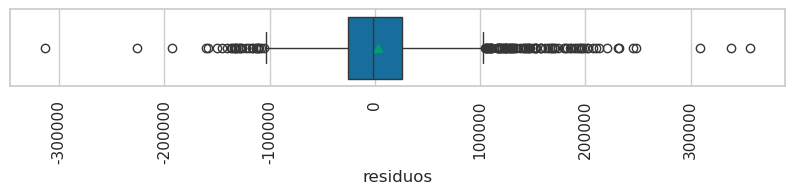

In [24]:
display(
    df_describe[['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean', 'std',
    ]].style.background_gradient(
        cmap=PALETTE_TEMPERATURA,
        axis='columns',
        subset=['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean',]
    )
)

# boxplot
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(
    data=df_residuos,
    x='residuos',
    showmeans=True,
    ax=ax,
)
# Definindo a orientação dos tick labels do eixo x na vertical
ax.set_xticklabels(
    labels=[int(x) for x in ax.get_xticks()],
    rotation=90,
)
plt.show()

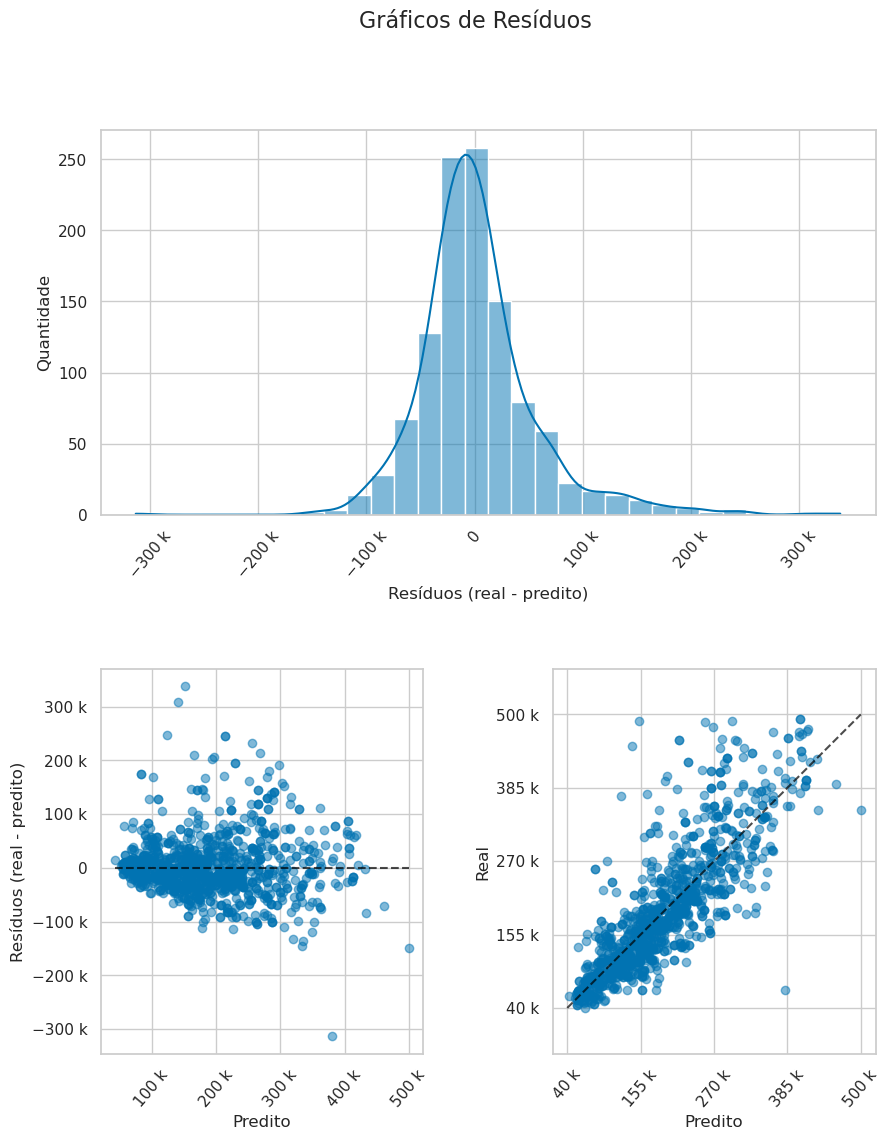

In [25]:
plot_residuos_estimador(grid_search.best_estimator_, X_validation, y_validation, fracao_amostra=0.6, eng_formatter=True) #, mosaico='bc;aa')

### Analisando os dados e gráficos de resíduos
Não podeos notar muita diferença entre nossos novos gráficos e os gráficos da etapa anterior.

No entanto é importante destacar que o modelo está com melhor score, mas ao custo de uma maior complexidade. Uma regularização Lasso pode ajudar a reduzir essa complexidade, mas vamos na próxima etapa experimentar o ElasticNet para verificar se devemos de fato avançar para o Lasso, para o Bridge ou se paramos no ElascticNet.

Também é importante observar que não temos uma situação de overfitting, pois os dados de validação não participaram do treinamento e ainda assim os resíduos estão próximos que já conhecíamos de etapas anteriores.